**Chapter 15 – Processing Sequences Using RNNs and CNNs**

# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Basic RNNs

### Generate the Dataset

In [3]:
windows = 50
horizon = 1 

In [4]:
def generate_time_series(batch_size, windows):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, windows)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 9 + 9))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 19 + 19)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, windows) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
np.random.seed(42)



series = generate_time_series(3000, windows + horizon)
X_train, y_train = series[:1000, :windows], series[:1000, -horizon:, 0]
X_valid, y_valid = series[1000:2000, :windows], series[1000:2000, -horizon:, 0]
X_test, y_test = series[2000:, :windows], series[2000:, -horizon:, 0]

In [6]:
X_train.shape, y_train.shape

((1000, 50, 1), (1000, 1))

In [7]:
def plot_series(series, windows, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windows, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(windows, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, windows + 1, -1, 1])

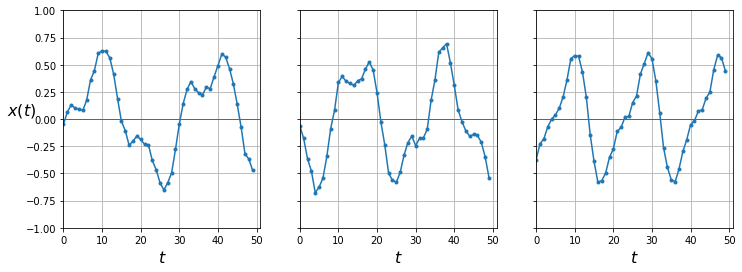

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    #plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col==0 else None))
    plot_series(X_valid[col, :, 0], windows, y_label=("$x(t)$" if col==0 else None))

plt.show()

In [9]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [10]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.01627411

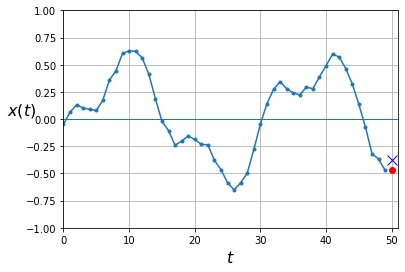

In [11]:
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[windows, 1]),
    keras.layers.Dense(horizon)
])

In [36]:
mae = tf.keras.metrics.MeanAbsoluteError()

In [37]:
#model_1.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])

model_1.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[mae])

history_1 = model_1.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
32/32 [==============================] - 0s 8ms/step - loss: 0.0901 - mean_absolute_error: 0.2391 - val_loss: 0.0363 - val_mean_absolute_error: 0.1537
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0252 - mean_absolute_error: 0.1267 - val_loss: 0.0167 - val_mean_absolute_error: 0.1045
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0966 - val_loss: 0.0130 - val_mean_absolute_error: 0.0908
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0879 - val_loss: 0.0107 - val_mean_absolute_error: 0.0820
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_absolute_error: 0.0808 - val_loss: 0.0101 - val_mean_absolute_error: 0.0800
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0745 - val_loss: 0.0085 - val_mean_absolute_error: 0.0729
Epoch 7/20
32/32 [==========

In [38]:
model_1.evaluate(X_valid, y_valid)

32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_absolute_error: 0.0504


[0.003951646853238344, 0.05042834207415581]

In [39]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

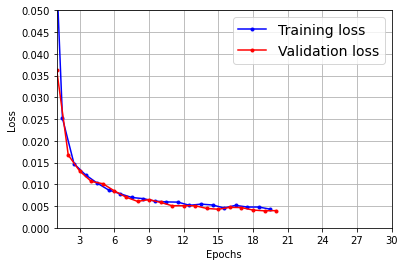

In [40]:
plot_learning_curves(history_1.history["loss"], history_1.history["val_loss"])
plt.show()

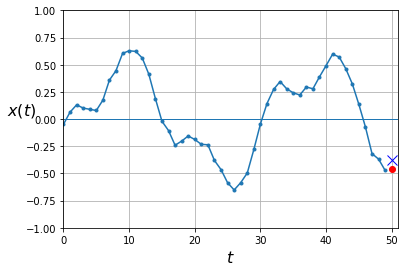

In [41]:
y_pred = model_1.predict(X_valid)
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

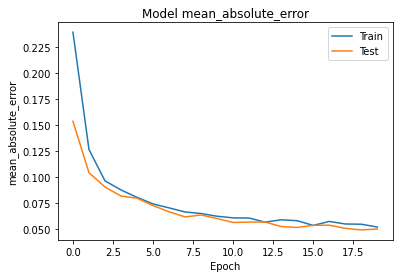

In [46]:
plt.plot(history_1.history['mean_absolute_error'])
plt.plot(history_1.history['val_mean_absolute_error'])
plt.title('Model mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Using a Simple RNN

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model_2 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model_2.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_2 = model_2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 3s 85ms/step - loss: 0.1649 - last_time_step_mse: 0.1634 - val_loss: 0.0788 - val_last_time_step_mse: 0.0796
Epoch 2/30
32/32 [==============================] - 3s 83ms/step - loss: 0.0670 - last_time_step_mse: 0.0671 - val_loss: 0.0525 - val_last_time_step_mse: 0.0530
Epoch 3/30
32/32 [==============================] - 3s 79ms/step - loss: 0.0479 - last_time_step_mse: 0.0479 - val_loss: 0.0413 - val_last_time_step_mse: 0.0416
Epoch 4/30
32/32 [==============================] - 3s 84ms/step - loss: 0.0387 - last_time_step_mse: 0.0387 - val_loss: 0.0339 - val_last_time_step_mse: 0.0340
Epoch 5/30
32/32 [==============================] - 3s 81ms/step - loss: 0.0331 - last_time_step_mse: 0.0329 - val_loss: 0.0293 - val_last_time_step_mse: 0.0294
Epoch 6/30
32/32 [==============================] - 3s 79ms/step - loss: 0.0287 - last_time_step_mse: 0.0284 - val_loss: 0.0259 - val_last_time_step_mse: 0.0260
Epoch 7/30
32/32 [================

In [22]:
model_2.evaluate(X_valid, y_valid)

32/32 [==============================] - 0s 8ms/step - loss: 0.0098 - last_time_step_mse: 0.0098


[0.009829442948102951, 0.00982597004622221]

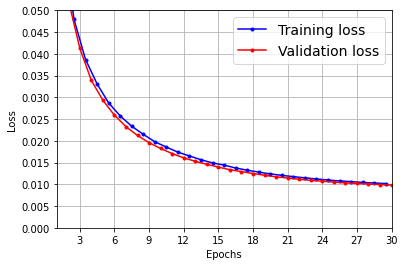

In [23]:
plot_learning_curves(history_2.history["loss"], history_2.history["val_loss"])
plt.show()

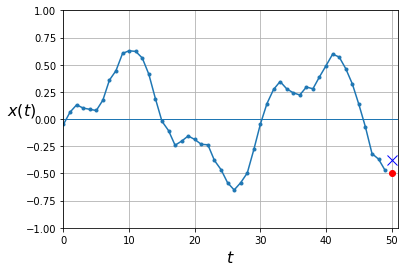

In [25]:
y_pred = model_2.predict(X_valid)
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

### model 3: Deep RNNs with return_sequences=True

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model_3 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(horizon)
])

model_3.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_3 = model_3.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 10s 283ms/step - loss: 0.2052 - last_time_step_mse: 0.2017 - val_loss: 0.0429 - val_last_time_step_mse: 0.0425
Epoch 2/30
32/32 [==============================] - 10s 297ms/step - loss: 0.0214 - last_time_step_mse: 0.0210 - val_loss: 0.0124 - val_last_time_step_mse: 0.0123
Epoch 3/30
32/32 [==============================] - 10s 303ms/step - loss: 0.0068 - last_time_step_mse: 0.0068 - val_loss: 0.0045 - val_last_time_step_mse: 0.0045
Epoch 4/30
32/32 [==============================] - 9s 295ms/step - loss: 0.0049 - last_time_step_mse: 0.0049 - val_loss: 0.0045 - val_last_time_step_mse: 0.0045
Epoch 5/30
32/32 [==============================] - 9s 297ms/step - loss: 0.0044 - last_time_step_mse: 0.0044 - val_loss: 0.0043 - val_last_time_step_mse: 0.0043
Epoch 6/30
32/32 [==============================] - 9s 276ms/step - loss: 0.0040 - last_time_step_mse: 0.0040 - val_loss: 0.0039 - val_last_time_step_mse: 0.0039
Epoch 7/30
32/32 [=======

In [27]:
model_3.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 23ms/step - loss: 0.0042 - last_time_step_mse: 0.0042 0s - loss: 0.0042 - last_time_step_mse: 0.00


[0.004209588281810284, 0.004211410880088806]

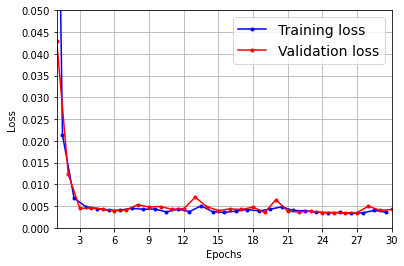

In [28]:
plot_learning_curves(history_3.history["loss"], history_3.history["val_loss"])
plt.show()

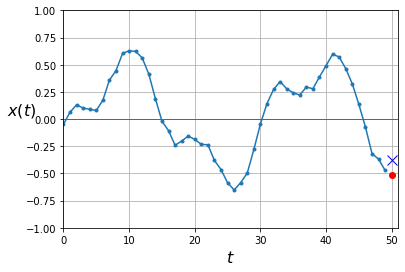

In [29]:
y_pred = model_3.predict(X_valid)
plot_series(X_valid[0, :, 0], windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

### model 4: the second SimpleRNN layer return only the last output

Make the second `SimpleRNN` layer return only the last output:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model_4 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])

model_4.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_4 = model_4.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
32/32 [==============================] - 7s 194ms/step - loss: 0.0578 - last_time_step_mse: 0.0566 - val_loss: 0.0056 - val_last_time_step_mse: 0.0056
Epoch 2/20
32/32 [==============================] - 6s 182ms/step - loss: 0.0044 - last_time_step_mse: 0.0045 - val_loss: 0.0037 - val_last_time_step_mse: 0.0037
Epoch 3/20
32/32 [==============================] - 6s 190ms/step - loss: 0.0037 - last_time_step_mse: 0.0037 - val_loss: 0.0038 - val_last_time_step_mse: 0.0038
Epoch 4/20
32/32 [==============================] - 6s 176ms/step - loss: 0.0035 - last_time_step_mse: 0.0034 - val_loss: 0.0035 - val_last_time_step_mse: 0.0035
Epoch 5/20
32/32 [==============================] - 6s 192ms/step - loss: 0.0032 - last_time_step_mse: 0.0032 - val_loss: 0.0034 - val_last_time_step_mse: 0.0033- last
Epoch 6/20
32/32 [==============================] - 6s 187ms/step - loss: 0.0033 - last_time_step_mse: 0.0033 - val_loss: 0.0035 - val_last_time_step_mse: 0.0035
Epoch 7/20
32/32 [====

In [31]:
model_4.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 16ms/step - loss: 0.0034 - last_time_step_mse: 0.0034 0s - loss: 0.0033 - last_time_step_mse


[0.003396162996068597, 0.0033666568342596292]

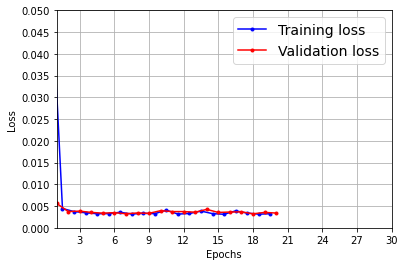

In [32]:
plot_learning_curves(history_4.history["loss"], history_4.history["val_loss"])
plt.show()

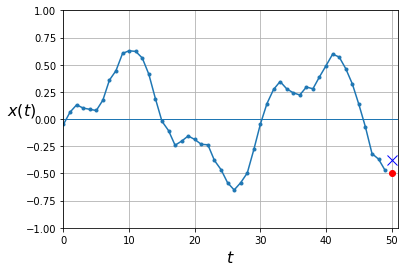

In [33]:
y_pred = model_4.predict(X_valid)
plot_series(X_valid[0, :, 0], windows, y_valid[0, 0], y_pred[0, 0])
plt.show()